# Compare **hkl_soleil** **E4CV** with **SPEC** **fourc**

Following the E4CV [example](./hkl_soleil-e4cv.ipynb), compare the orientation matix and
positioning operations of **hkl_soleil** **E4CV** with **SPEC** **fourc**

Information from a **SPEC** data file will be used for the comparison.

In SPEC *fourc* [geometry](https://certif.com/spec_help/fourc.html):

SPEC name   | mnemonic   | description
-----       | -----      | -----
2theta      | tth        | Detector arm rotation
Theta       | th         | Rotates sample circles
Chi         | chi        | Sample tilt
Phi         | phi        | Sample rotation

The provided SPEC data file names these motors: `tth`, `th`, `chi`, `phi` so
this example will use the same names with the *E4CV* diffractometer to help the
comparison.

## Read the SPEC scan from the data file

The SPEC file provides all the information needed here.  The
[*spec2nexus*](https://github.com/prjemian/spec2nexus) 
(python) package can read the file and parse the content into useful 
structures, including deducing the diffractometer geometry in many cases.

In [1]:
import pyRestTable
from spec2nexus.spec import SpecDataFile

specfile = SpecDataFile("LNO_LAO_s14.dat")
specscan = specfile.getScan(14)

spec_d = specscan.diffractometer
spec_d.UB = spec_d.geometry_parameters["ub_matrix"][2]

terms = {
    "SPEC file": specfile.specFile,
    "scan #": specscan.scanNum,
    "SPEC scanCmd": specscan.scanCmd,
    "geometry": spec_d.geometry_name,
    "mode": spec_d.mode,
    "lattice": spec_d.lattice,
    "wavelength": spec_d.wavelength,
    "reflection 1": spec_d.reflections[0],
    "reflection 2": spec_d.reflections[1],
    "[UB]": spec_d.UB,
}
tbl = pyRestTable.Table()
tbl.labels = "term value".split()
for k, v in terms.items():
    tbl.addRow((k, v))
print(tbl)

============ =================================================================================================================================================
term         value                                                                                                                                            
============ =================================================================================================================================================
SPEC file    LNO_LAO                                                                                                                                          
scan #       14                                                                                                                                               
SPEC scanCmd hklscan  1.00133 1.00133  1.00133 1.00133  2.85 3.05  200 -400000                                                                                
geometry     fourc                            

## Plot the (_hkl_) trajectories in the scan

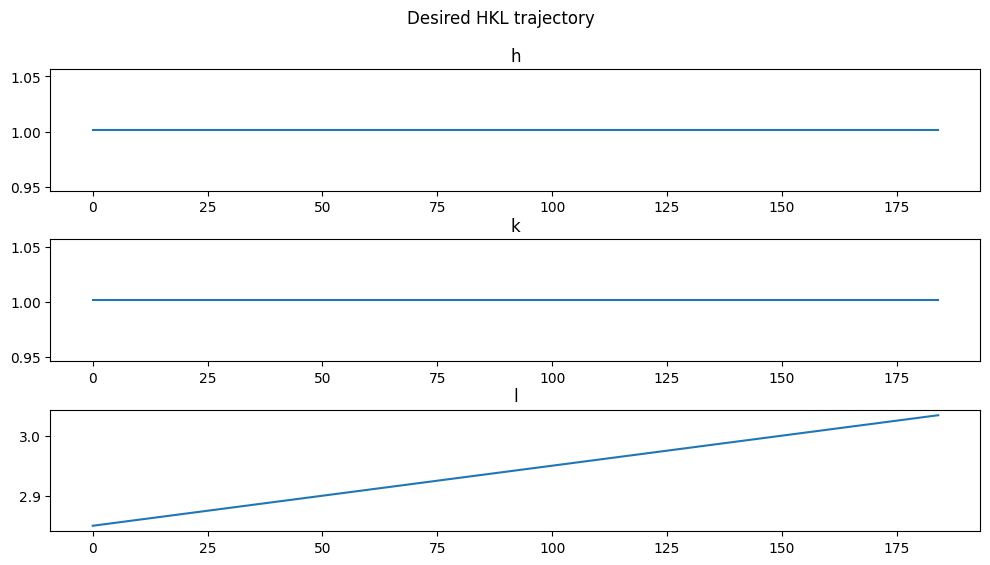

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

# plot the h, k, & l vs. point number
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.suptitle('Desired HKL trajectory')
axes[0].plot(specscan.data["H"])
axes[0].set_title("h")
axes[1].plot(specscan.data["K"])
axes[1].set_title("k")
axes[2].plot(specscan.data["L"])
axes[2].set_title("l")
plt.show()

## Setup the *E4CV* diffractometer in *hklpy*

In [3]:
import hklpy2

fourc = hklpy2.creator(
    name="fourc",
    geometry="E4CV",
    solver="hkl_soleil",
    # use SPEC names for the axes and simulated motors (not EPICS)
    reals=dict(th=None, chi=None, phi=None, tth=None),
)

In [4]:
# add the sample to the calculation engine
from hklpy2.user import add_sample, calc_UB, set_diffractometer, setor

set_diffractometer(fourc)
add_sample(
    specfile.specFile,  # sample name
    a=spec_d.lattice.a, 
    b=spec_d.lattice.b, 
    c=spec_d.lattice.c,
    alpha=spec_d.lattice.alpha, 
    beta=spec_d.lattice.beta, 
    gamma=spec_d.lattice.gamma,
)

Sample(name='LNO_LAO', lattice=Lattice(a=3.7817, b=3.7914, c=3.7989, alpha=90.2546, beta=90.0182, gamma=89.8997, system='triclinic'))

## Test *hklpy* with the **UB** orientation matrix from **SPEC**

Using the UB matrix as provided in the SPEC data file, 
compute the forward reflection positions and compare with
those calculated by **libhkl**.

In [5]:
fourc.sample.UB

[[1.6614596270567616, 0.0, 0.0],
 [0.0, 1.6614596270567616, 0.0],
 [0.0, 0.0, 1.6614596270567616]]

In [6]:
# get the UB matrix from the SPEC data
# SPEC's UB first row moved (via numpy slicing) to last row for hklpy
fourc.sample.UB = spec_d.UB[[1,2,0], :]
print(f"{spec_d.UB=}")
print(f"{fourc.sample.UB}=")

# calculate angles with hklpy using the SPEC UB matrix
fourc.mode = "bissector"
fourc.core.constraints["phi"].limits = (-50, 100)
fourc.core.constraints["tth"].limits = (-2, 180)
print(f"(002) : {fourc.forward(0, 0, 2)}")
print(f"(113) : {fourc.forward(1, 1, 3)}")

spec_d.UB=array([[-1.65871244e+00,  9.82002413e-02, -3.89705578e-04],
       [-9.55499031e-02, -1.65427863e+00,  2.42844486e-03],
       [ 2.62981891e-04,  9.81574682e-03,  1.65396181e+00]])
[[-9.55499031e-02 -1.65427863e+00  2.42844486e-03]
 [ 2.62981891e-04  9.81574682e-03  1.65396181e+00]
 [-1.65871244e+00  9.82002413e-02 -3.89705578e-04]]=
(002) : Hklpy2DiffractometerRealPos(th=15.262191782015, chi=89.914805456892, phi=99.115948808545, tth=30.52438356403)
(113) : Hklpy2DiffractometerRealPos(th=25.930677549264, chi=115.202910930796, phi=48.133061382025, tth=51.861355098529)


Define a custom reporting function to format the output table.

In [7]:
def add_ref_to_table(tbl, r):
    sol = fourc.forward(r.h, r.k, r.l)
    nm = f"{r.h:.0f} {r.k:.0f} {r.l:.0f}"
    # print(nm, sol)
    for sm in fourc.real_axis_names:
        row = [f"({nm})", sm]
        v_hklpy = getattr(sol, sm)
        v_spec = r.angles[sm]
        row.append(f"{v_hklpy:.5f}")
        row.append(f"{v_spec:.5f}")
        row.append(f"{v_hklpy-v_spec:.5f}")
        tbl.addRow(row)

For each of the orientation reflections used in the SPEC file,
report the computed motor positions for each reflection for 
E4CV and SPEC.  We'll only pick positions where $2\theta\ge 0$.

In [8]:
# Compare these angles with those from SPEC

tbl = pyRestTable.Table()
tbl.labels = "(hkl) motor E4CV SPEC difference".split()
r1, r2 = spec_d.reflections

fourc.core.mode = "bissector"
fourc.core.constraints["tth"].limits = (-2, 180)
add_ref_to_table(tbl, r1)

# print(r2)
add_ref_to_table(tbl, r2)

print(tbl)

======= ===== ========= ========= ==========
(hkl)   motor E4CV      SPEC      difference
======= ===== ========= ========= ==========
(0 0 2) th    15.26219  19.13350  -3.87131  
(0 0 2) chi   89.91481  90.01350  -0.09869  
(0 0 2) phi   99.11595  0.00000   99.11595  
(0 0 2) tth   30.52438  38.09875  -7.57437  
(1 1 3) th    25.93068  32.82125  -6.89057  
(1 1 3) chi   115.20291 115.23625 -0.03334  
(1 1 3) phi   48.13306  48.13150  0.00156   
(1 1 3) tth   51.86136  65.64400  -13.78264 
======= ===== ========= ========= ==========



Note that the angles do not match between *E4CV* and *SPEC*,
even if we re-arrange the rows as we did above.  Can't just
use the UB matrix from the one program in the other
software.

Need to add the orientation reflections (with wavelength),
then compute the UB matrix.  Follow in the section below.

## Setup the **UB** orientation matrix using *hklpy*

Compute the UB matrix using *hklpy* (& *libhkl*).

In [9]:
fourc.beam.wavelength.put(1.239424258) # Angstrom

refs = [
    setor(
        r.h, r.k, r.l, 
            tth=r.angles["tth"],
            th=r.angles["th"],
            chi=r.angles["chi"],
            phi=r.angles["phi"],
    )
    for r in spec_d.reflections
]

UB = calc_UB(*refs)

tbl = pyRestTable.Table()
tbl.labels = "term value".split()
tbl.addRow(("SPEC [UB]", spec_d.UB))
tbl.addRow(("E4CV [UB]", UB))
print(tbl)

========= ==========================================================================================================================================================
term      value                                                                                                                                                     
========= ==========================================================================================================================================================
SPEC [UB] [[-1.65871244e+00  9.82002413e-02 -3.89705578e-04]                                                                                                        
           [-9.55499031e-02 -1.65427863e+00  2.42844486e-03]                                                                                                        
           [ 2.62981891e-04  9.81574682e-03  1.65396181e+00]]                                                                                                       
E4CV [UB] 

Report the results, as before, and compare with table above.

In [10]:
fourc.sample.lattice.crystal_system

'triclinic'

In [11]:
tbl = pyRestTable.Table()
tbl.labels = "term value".split()
tbl.addRow(("energy, keV", fourc.beam.energy.get()))
tbl.addRow(("wavelength, angstrom", fourc.beam.wavelength.get()))
tbl.addRow(("position", fourc.position))
tbl.addRow(("sample name", fourc.sample.name))
tbl.addRow(("lattice", fourc.sample.lattice))
tbl.addRow(("crystal system", fourc.sample.lattice.crystal_system))
tbl.addRow(("[U]", fourc.sample.U))
tbl.addRow(("[UB]", fourc.sample.UB))
print(tbl)

==================== ==========================================================================================================================================================
term                 value                                                                                                                                                     
==================== ==========================================================================================================================================================
energy, keV          10.003370326044433                                                                                                                                        
wavelength, angstrom 1.239424258                                                                                                                                               
position             Hklpy2DiffractometerPseudoPos(h=0, k=0, l=0)                                                       

In [12]:
# Compare these angles with those from SPEC
# fourc.calc["phi"].limits = (-1, 100)
tbl = pyRestTable.Table()
tbl.labels = "(hkl) motor E4CV SPEC difference".split()
r1, r2 = spec_d.reflections
fourc.core.constraints["tth"].limits = (-2, 180)

fourc.core.mode = "constant_phi"
fourc.phi.move(0)
add_ref_to_table(tbl, r1)

fourc.core.mode = "bissector"
add_ref_to_table(tbl, r2)

print(tbl)

======= ===== ========= ========= ==========
(hkl)   motor E4CV      SPEC      difference
======= ===== ========= ========= ==========
(0 0 2) th    19.12617  19.13350  -0.00733  
(0 0 2) chi   90.01350  90.01350  -0.00000  
(0 0 2) phi   0.00000   0.00000   0.00000   
(0 0 2) tth   38.08407  38.09875  -0.01468  
(1 1 3) th    32.81850  32.82125  -0.00275  
(1 1 3) chi   115.20290 115.23625 -0.03335  
(1 1 3) phi   48.13304  48.13150  0.00154   
(1 1 3) tth   65.63700  65.64400  -0.00700  
======= ===== ========= ========= ==========



---

## SPEC data file

In [13]:
%pycat LNO_LAO_s14.dat

#F LNO_LAO
#E 1276730676
#D Wed Jun 16 18:24:36 2010
#C LNO_LAO  User = epix33bm
#H0  SR_current  SR_fill  SR_status  SR_mode  SR_fb  SR_fbH  SR_fbV  SR_topUp  barometer_mbar
#H1  SR_BM_HPOS  SR_BM_VPOS  SR_BM_HANG  SR_BM_HANG
#H2  slits_wt  slits_wl  slits_wb  slits_wr
#H3  Mir1_alpha  Mir1_y  Mir1_y1  Mir1_y2  Mir1_bender
#H4  DCM_energy  DCM_lambda  DCM_theta0  DCM_thetaEnc  DCM_mode  Mir_use  Mir_alpha
#H5  Mir2_alpha  Mir2_y  Mir2_y1  Mir2_y2  Mir2_bender
#H6  mue_sclr_auto  mue_sclr_freq
#H7  PF4_thickAl  PF4_thickTi  PF4_trans  PF4_bladeA1  PF4_bladeA2  PF4_bladeA3  PF4_bladeA4  PF4_bladeB1  PF4_bladeB2  PF4_bladeB3  PF4_bladeB4
#H8  I0_VDC  I0_gain  I0_bias  I0_time  I0_suppr  I0_dark  I0_Amps
#H9  I00_VDC  I00_gain  I00_bias  I00_time  I00_suppr  I00_dark  I00_Amps
#H10  MUE540_i0  MUE540_i1  MUE540_i2  MUE540_i3  MUE540_i4  MUE540_i5  MUE540_i6  MUE540_i7
#H11  MUE540_i8  MUE540_i9  MUE540_i10  MUE540_i11  MUE540_i12  MUE540_i13  MUE540_i14  MUE540_i15
#H12  MUE540_o0  MUE540